IVADO Recommender Systems Workshop. August 19, 2019.
=======

Tutorial: An Introduction to Practical Machine Learning
=============


This tutorial provides a short introduction to the practice of machine learning. 

We assume that the user already has an understanding of the basic concepts that underlie the field. We review both methodological concepts like supervised and unsupervised learning, and also use software libraries such as scikit-learn, pandas, and numpy. 

In particular, we will:
1. load some data, 
2. fit different supervised models on variations of the data, including a variation where some of the features have been clustered, 
3. and compare results.

This tutorial is not meant to be exhaustive (references are provided throughout, and links to extra material are provided at the end).  

### Authors: 
- Laurent Charlin <lcharlin@gmail.com>
- David Berger <davidberger2785@gmail.com>
- Didier Chetelat <didier.chetelat@polymtl.ca>

### Table of Content

- [Section 0. Introduction](#introduction)
- [Section 1. Data Pre-Processing](#pre-processing)
- [Section 2. Modelling](#modelling)
- [Section 3. Concluding Remarks](#concluding-remarks)

<a id='introduction'></a>
### Section 0. Introduction
As the introduction to a recommender-systems workshop we will model user-movie preferences from a popular publicly available dataset (Movielens 1M). We will learn, from past user-movie ratings, to predict (missing/future) user-movie ratings from user socio-demographics and movie-tags data.

Mathematically, we are interested in learning the (parameters of the) following function: 

$$ r_{um} = f_\theta(x_u, x_m)$$ 
where 
- $u$ indexes users 
- $m$ indexes items
- $r_{um}$ is u's rating for m (that user's preference) -- the dependent variable
- $f_\theta$ is some model parametrized by $\theta$. For example, a linear regression with coefficients $\theta$
- $x_u$ are user u's covariates (e.g., age and occupation of this user)
- $x_m$ are movie m's covariates (e.g., tags associated with the movie)

The function $f$ can take several forms (in other words, we can use a variety of models for this task). In today's tutorial we will assume that the problem is a regression one and we will experiment with several models ranging from a simple linear regression model to a more complicated two-hidden layer neural network.


### Machine Learning terminology

It can be useful to think of machine learning as comprising three elements:
1. Task (T)
2. Experience (E)
3. Performance measure (P).

(a good description of these concepts is provided in [Ch. 5 of the Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html))

The intuition is that the task (T) is "the type of problem you are trying the solve" (e.g., classification, regression, anomaly detection), the experience (E) is "how your data comes about" (e.g., does it come with labels or not, do you observe it all at once or as a stream), and the performance (P) is "how well your model does". Standard performance measures include accuracy and mean squared error.  

Note that the above terminology does not define the model used to learn (fit) the data nor does it define the fitting procedure (e.g., gradient descent).

Relationship to the problem of rating prediction:
- Task: Our task is to predict user-movie ratings. It can be modelled in different ways (more on this tomorrow), but here we will model it as a regression problem. 
- Experience: The experience is a supervised learning one because we are predicting some dependent variable (rating) from a set of independent variables
- Performance measure: We will be using the mean-squared error.

### Setting up the data 

For supervised learning, it is customary, to construct two data matrix $X$ and $Y$. The former, $X$, contains the covariates (features). It is a matrix of size $n \times p$ with $n$ the number of examples and $p$ the dimensionality of each example (in other words the number of covariates associated with each example).  They are the input to the function. 

$$X = \begin{bmatrix} 
x_{11} & x_{12} & \ldots & x_{1p} \\
\vdots & \ddots       &  \ddots      & \vdots \\ 
x_{n1} & x_{12} & \ldots & x_{np} \\
\end{bmatrix}
$$ 

The latter, $Y$, is a (column) vector of length $n$ which contains the labels (here ratings). $Y_1$ corresponds to the rating of $X_1$ (row  contains the labels (here ratings).

$$
Y = \begin{bmatrix} 
r_1 \\
r_2 \\
\vdots \\ 
r_n
\end{bmatrix}$$

Of course, in a real problem we will differentiate the `train` and `test` sets, e.g., with $X_\text{train}$ and $X_\text{test}$. Same for the labels using, e.g., $Y_\text{train}$ and $Y_\text{test}$.

## Start

Following this brief introduction, we now dive into the problem. 

In [1]:
# We first download the repo to get access to data and some utility code (This is specifically for colab.)
!rm -rf ivado-workshop_recsys_19
!git clone https://github.com/lcharlin/ivado-workshop_recsys_19/

Cloning into 'ivado-workshop_recsys_19'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 48 (delta 14), reused 42 (delta 11), pack-reused 0
Unpacking objects: 100% (48/48), done.


We begin by importing some of the packages that we will need: 
- `reduce` function will come in handy to iteratively process data
- `os` as a standard packages for performing system operations (e.g., opening files)
- `re` package for regex
- `sys` package to deal with system-level operations (here used to change the search path) 
- `time` package we will use to measure the length of certain operations



- `matplotlib` for plotting
- `numpy` for linear-algebra computations
- `pandas` for data wrangling 
- `sklearn` (scikit-learn) for machine learning models and useful machine learning related routines

In [2]:
from functools import reduce
import os
import re 
import time

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import neural_network

import sys
sys.path += ['ivado-workshop_recsys_19/']
from local_utils import DrawNN

<a id='pre-processing'></a>
# Section 1: Data Pre-Processing

In the following we are going to load data from several csv files and pre-process it. 

While this is not really machine learning, machine learning needs data and so knowing how to manipulate (and plot) data in python is quite useful. (In fact, in lots of use cases, data acquisition and cleaning will often take more of your time than running the machine learning models.)

#### Details

We will use the publically available [movielens dataset](https://grouplens.org/datasets/movielens/). The group behind movielens has released several useful datasets in the last 20 years. Here we will focus on the [ML-1M data](https://grouplens.org/datasets/movielens/1m/) (it contains 1M ratings) but we will also use movie tags from the [ML-20M dataset](https://grouplens.org/datasets/movielens/20m/) (20M ratings). 

Except for downloading the dataset (to save you some time), I have not processed nor modified the data in any way.

In [3]:
ROOT_DIR='ivado-workshop_recsys_19/'
DATA_DIR=os.path.join(ROOT_DIR, 'dat/ml-1m/') # this is where most of our data lives
DATA_DIR_20ML=os.path.join(ROOT_DIR, 'dat/ml-20m/') # for the tags data

We begin by loading the data that describes the movies in the ML-1M dataset. Each line in the file contains one entry in the following format `MovieID::Name::Genres`. 

After loading into a pandas `dataFrame` structure, we will have movie names (`mName`), IDs (`mid`), and movie genres (`mGenres`)

In [4]:
movies_pd = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'), 
                        sep='::', 
                        names=['mid', 'mName', 'mGenres'], engine='python')

In [5]:
print(f'The dataset contains {movies_pd.shape[0]} movies')

The dataset contains 3883 movies


In [6]:
display(movies_pd.head())

,mid,mName,mGenres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Using pandas we can also search for movies by `mid` or by their name:

In [7]:
mid = 10 
display(movies_pd[movies_pd.mid==mid])

name = 'Machine'
display(movies_pd[movies_pd.mName.str.contains(name, 
                                               regex=False, case=False)])

,mid,mName,mGenres
9,10,GoldenEye (1995),Action|Adventure|Thriller


,mid,mName,mGenres
1409,1433,"Machine, The (1994)",Comedy|Horror


Using a similar routine as above, we load the ratings data which is in this format `UserID::MovieID::Rating::Timestamp`, and we will name the column UserID with `uid`, the column MovieID with `mid`, the rating with `rating`, and the time of the rating with `timestamp`.

In [8]:
ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), 
                         sep='::',
                         names=['uid', 'mid', 'rating', 'timestamp'],
                         parse_dates=['timestamp'],
                         infer_datetime_format=True,
                         engine='python')

display(ratings_pd.head())

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
print(f"""The dataset contains {ratings_pd.shape[0]} ratings, 
      from {ratings_pd.uid.nunique()} users, 
      and {ratings_pd.mid.nunique()} items.""")

The dataset contains 1000209 ratings, 
      from 6040 users, 
      and 3706 items.


Load user socio-demographics information.

The file is in this format `UserID::Gender::Age::Occupation::Zip-code`, which we will load in a `dataFrame` with the following column names `uid,gender,age,occupation,zip`. 



In [10]:
users_pd = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'),
                       sep='::',
                       names=['uid', 'gender', 'age', 'occupation', 'zip'],
                       engine="python")

display(users_pd.head())

,uid,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
print(f'This table contains {users_pd.shape[0]} users')

This table contains 6040 users


Further we will truncate the 5-digit zip codes and only keep the leading two digits. The reason is that we will treat this variable as a categorical one and with only ~6K users and >3.4K unique zip codes, it is unlikely that we can learn precise enough coefficients for this feature. 

In [12]:
print(f'We originally have {users_pd.zip.nunique()} different zip codes')
users_pd['zip'] = users_pd['zip'].apply(lambda x: x[:2])
display(users_pd['zip'].head())
print(f'By only keep the first two digits of each zip code, we reduced the unique number of zip codes to {users_pd.zip.nunique()}.')

We originally have 3439 different zip codes


0    48
1    70
2    55
3    02
4    55
Name: zip, dtype: object

By only keep the first two digits of each zip code, we reduced the unique number of zip codes to 100.


The remaining data to be loaded are the movie tags (we will actually use the tags from the ml-20M dataset). The tags are user generated. Further each movie-tag pair comes with an affinity score (intuitively, if numerous users have used a tag on a particular movie than the tag-movie pair will have a high affinity).

We will load the csv data `movieId,tagId,relevance` into a `dataFrame` with the columns `mid,tid,relevance`. 

In [13]:
# load ml-20m tags
tags_scores = pd.read_csv(os.path.join(DATA_DIR_20ML, 'genome-scores.csv.gz'), 
                          skiprows=1, 
                          names=['mid', 'tid', 'relevance'])
display(tags_scores.head(10))

,mid,tid,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [14]:
print(f'The data contains {tags_scores.tid.nunique()} unique tags.')
print(f'Affinities (relevances) are contained in the {tags_scores.relevance.min()}--{tags_scores.relevance.max()} range.')
display(tags_scores.relevance.describe())

The data contains 1128 unique tags.
Affinities (relevances) are contained in the 0.00024999999999997247--1.0 range.


count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

From above we see that affinities (relevance) basically span the 0 to 1 range, and have an average of 0.12.

We also load the tag names. This will be useful for exploration purposes.

In [15]:
tags_names = pd.read_csv(os.path.join(DATA_DIR_20ML, 'genome-tags.csv'), skiprows=1, names=['tid', 'tName'])
display(tags_names.head(10))

,tid,tName
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


Since we loaded tag scores from a different dataset (ml-20M), we only need the tags that correspond to movies  in the original data (ml-1M). Luckily, since both datasets are from movielens, the movie ids (`mid`) are the same across these two datasets (i.e., not need for messy string match).

(Note: Pandas' functionalities allow you to do operations similar to what you would do with SQL with relational databases.)

In [16]:
tags_scores = tags_scores.loc[tags_scores['mid'].isin(ratings_pd['mid'].unique())]
print(tags_scores.mid.nunique())

3470


We lost a few movies compared to the original count of 3706 but we can live with that.

Next, instead of using the tag scores, we only keep the highly relevant tags for each movie. In other words, we assume that the presence of a tag is more meaningful than its absence. This also has the side benefit of reducing the number of available tags per movie. 

In [17]:
# Keep only high-relevance tags (here this is defined as having a relevance above 0.9)
print('unique tags:', tags_scores['tid'].nunique())
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]
print('unique tags w. high relevance:', tags_scores_high['tid'].nunique())

unique tags: 1128
unique tags w. high relevance: 968


#### Explore tags

Let's get some understanding of how these tags are used. To help, we first build a `dataFrame` that contains, the tag names, the movie name, and its relevance (recall that currently these are three different tables, as the tag relevance contains tag and movie IDs but not their names). 

Pandas' `merge` function can be used to join two dataFrames that share a common key. (This is an operation inspired by inner joinds in SQL.)

In [18]:
tags_high_names_movies = pd.merge(tags_scores_high, tags_names, how='inner', on='tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movies_pd, how='inner', on='mid')
display(tags_high_names_movies.head())

,mid,tid,relevance,tName,mName,mGenres
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy


Similarly as above we can search for top movies according to a particular tag: 

In [19]:
tag = 'scary' # This is the (sub) tag we search for
display(tags_high_names_movies[
    tags_high_names_movies.tName.str.contains(tag, 
                                               regex=False, case=False)].sort_values(by=['relevance'],
                                                                                    ascending=False))

,mid,tid,relevance,tName,mName,mGenres
13151,2710,882,0.96700,scary,"Blair Witch Project, The (1999)",Horror
14005,1342,882,0.96625,scary,Candyman (1992),Horror
9205,1347,882,0.96550,scary,"Nightmare on Elm Street, A (1984)",Horror
14658,3892,882,0.96475,scary,Anatomy (Anatomie) (2000),Horror
3187,1997,882,0.96200,scary,"Exorcist, The (1973)",Horror
14021,2550,882,0.95625,scary,"Haunting, The (1963)",Horror|Thriller
11492,1350,882,0.94675,scary,"Omen, The (1976)",Horror
11546,2841,882,0.94650,scary,Stir of Echoes (1999),Thriller
9340,1974,882,0.94625,scary,Friday the 13th (1980),Horror
2976,1387,882,0.94250,scary,Jaws (1975),Action|Horror


This next step will allow us to further explore the tags data while providing an additional step of pre-processing that will be helpful for fitting this data. 

In the current dataset, every movie-tag id pair is a separate entry (row of the `dataFrame`). Thinking ahead, we will want to use all tags as covariates to predict a single rating. As such, we want to construct a data matrix where each line corresponds to a single example. 

To do so, re-encode `tid`s using a 1-of-K encoding or dummy variables. This is important to encode categorial variables (e.g., "cats" and "dogs") which may be represented numerically but where there is not order. For example, here each tag has a numerical index (e.g., tag `scary` is id `882`) but tags cannot be compared using their numbers (e.g., tag `882` is not "bigger" than tag `880` or smaller than tag `900`). 1-of-K encoding deals with this by encoding each tag as a binary vector of length $K$ with a single non-zero value which corresponds to the tags. In the present case, $K=968$ tags, and tag `scary` would have a `1` at position `882`. 

Below we see that our data now has 971 columns: 968 for tag ids, 1 for `mid`, and 1 for `relevance`, and 1 for the pandas index.

In [20]:
#print(tags_scores_high.shape)
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns=['tid'])
tags_scores_high_dum = tags_scores_high_dum.reset_index()
#print(tags_scores_high_dum.shape)
display(tags_scores_high_dum.head())

,index,mid,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
0,62,1,0.93325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,1,0.98575,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,185,1,0.95650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,202,1,0.92625,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,203,1,0.96425,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With this data we can then explore the distribution of movies per tag (and tags per movie below). 

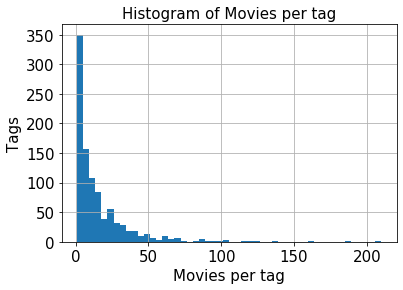

In [21]:
th = tags_scores_high.groupby("tid").count()
hists = th.hist(bins=50, column="mid", xlabelsize=15, ylabelsize=15)[0][0]
hists.set_ylabel("Tags", size=15)
hists.set_xlabel("Movies per tag", size=15)
hists.set_title("Histogram of Movies per tag", size=15);

In this histogram each bar corresponds to the number of tags (y-axis) associated with a particular number of movies. For example, there are 350 tags that were used to tag a small number of movies (<5). On the other hand, the most popular tag was used to tag 210 movies.

We note that the distribution is heavily skewed to the left which indicates that most tags are only used on a small number of movies.

In [22]:
tname = tags_names.at[tags_names.tid.eq(th.mid.idxmax()).idxmax(), 'tName']
print(f'The most popular tag "{tname}" has been used for {th.mid.max()} movies')

The most popular tag "comedy" has been used for 210 movies


Using the same recipe, we can do something similar for movies instead of tags

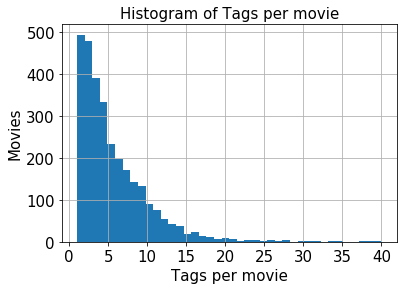

In [23]:
hists = tags_scores_high.groupby("mid").count().hist(bins=40, column="tid", xlabelsize=15, ylabelsize=15)
hists[0][0].set_ylabel("Movies", size=15)
hists[0][0].set_xlabel("Tags per movie", size=15)
hists[0][0].set_title("Histogram of Tags per movie", size=15);

In this histogram each bar corresponds to the number of movies (y-axis) associated with a particular number of tags. For example, there are a bit less than 500 movies that received exactly 1 tags. On the other hand, the most popular movie received almost 40 tags.

#### Question 1
What is the most popular movie in terms of tag (the one with almost 40 tags)? Bonus: Can you list the top 5 movies in terms of number of tags? 

In [24]:
mh = ...
mname = ...
print(f'The most popular movie "{mname}" has {mh.tid.max()} tags')

The most popular movie "Toy Story (1995)" has 40 tags


<a id='tag_clustering'></a>
# Section 1.1 Tag clustering

There are over 900 tags but most movies only contain a handful of tags (see above). In other words, tag representations for each movie (and equivalently for ratings) will be very sparse. For a given example, most covariates will be zero. 

This presents two challenges for machine learning methods: 
- We will need many parameterrs since we need one per tag, so 900 parameters for tags
- Each parameter will only be trained with a small number of data points which could make its estimation imprecise.

There are several ways to deal with this. One is to use an $L1$ penalty on the weights (more details [Lasso w. sklearn](https://scikit-learn.org/stable/modules/linear_model.html#lasso)), this is useful for the first challenge. Another is to reduce the dimensionality of the tag representation (initially 900). The intuition would be to capture dependencies between different tags and to use these dependencies to re-encode the tags of each movie using a lower-dimensional representation. 

Again, there are several ways of doing this. Here, we will use clustering. Clustering **groups** each data into a fixed number of groups. 

In this case, we first we cluster movies according to their tags. Then, we use the cluster of each movie as the covariate (instead of, or in addition to, the original representation). If there are 10 clusters, then we would reduce the dimensionality of the tag covariates from 900 to 10.

#### Clustering in scikit-learn

Scikit-learn proposes several clustering routines. Below we try three different ones. Before going into their details, let us first consider how to train a model using `scikit-learn`. 

Most models are trained in two steps:
1. instantiate the object: `model = sklearn.GreatModel(...)`)
2. Fit the object to data: `model.fit(X_train,Y_train)`

once the model is fit, it can be used to make predictions for missing data
3. Predict: `y_pred = model.predict(X_test)`

This API makes it very simple and efficient to experiment with different models in scikit-learn. As soon as the data is processed in a correct way, different methods can be easily compared.


Below we experiment with three different clustering models: 
1. [KMeans](https://scikit-learn.org/stable/modules/clustering.html#k-means): One of the standard clustering algorithms (it can be seen as a special case of other clustering techniques such as clustering using GMMs). It learns where to place *cluster centers* to best represent the data. A datum belongs to the cluster center that it is the closest to. When fitting, the objective is to minimize the sum of the distances between each datum and its center. This particular technique can be fit on large datasets but assumes Euclidean distances.  
2. [Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering). This is an instance of hierarchical clustering. In hierarchical clustering, points are recursively agglomerated (i.e., it goes from one cluster per point, to $n-1$ clusters, to $n-2$ clusters and so on) until a set number of clusters has been attained. Compared to KMeans, the distance metric and the objective can be altered to take into account different types of spaces.
3. [Affinity Propagation (AP)](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation): Provides a third methodology for clustering. Unlike Kmeans which uses cluster centers (agglomerative clustering does something similar implicitly), AP uses available data points as cluster centers, these are called *examplars*. Further, AP determines automatically the number of clusters for a dataset. In AP each datum sends messages to all other data. The messages contain information about the affinity for one datum to be the examplar for the other. The procedure is iterative and eventually converges to a clustering of all data.


#### How do you evaluate clustering

Unsupervised learning is ill-defined in that there is no objective measure of performance. For example, in clustering, different algorithms can optimize different losses and will yield different results. Different clusterings will then meet different desiderata and can be used under different scenarios. If data exploration is the goal, then having explainable clusters will make the most sense. If, on the other hand, the goal is to use the output into a downstream supervised model then the performance of that model can server as an indication of the quality of the clusters. 

In our problem we want to cluster movie represented by their tags: sparse binary vectors. It may make sense to use a [Hamming or L1 loss](https://en.wikipedia.org/wiki/Hamming_distance) then a euclidean loss. We will see below that the results are actually quite robust regardless of which loss we use.

In [25]:
n_clusters=100 # Number of clusters for KMeans and Agglometrive Clustering
method = 'KMeans' # Method to run: choices are {'KMeans', 'AgglomerativeClustering', 'AffinityPropagation'}

# setup data structures
tags_per_movie = tags_scores_high_dum.groupby("mid").sum()

movie_tags_cluster = pd.merge(movies_pd, tags_per_movie, how='inner', on='mid')
x_data = tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int)

print('Data to cluster:')
display(tags_per_movie.filter(regex="(tid_*)").head())

# launch clustering
if method == 'AgglomerativeClustering':
    aggClus = cluster.AgglomerativeClustering(n_clusters=n_clusters, affinity='l1', linkage='average')
    tags_cluster = aggClus.fit_predict(tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int))

elif method == 'KMeans':
    kmeansClus = cluster.KMeans(n_clusters=n_clusters, precompute_distances='auto')
    tags_cluster = kmeansClus.fit_predict(x_data)

elif method == 'AffinityPropagation':
    apClus = cluster.AffinityPropagation()
    tags_cluster = apClus.fit_predict(x_data)
    # AP automatically determines the number of clusters
    n_clusters = np.unique(tags_cluster).size
    print(n_clusters)

else:
    print('Unkown method', method)

print('Done clustering.')

Data to cluster:


,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,tid_10,tid_12,tid_13,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
mid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Done clustering.


One of the first things to look at is the number of datum per cluster:

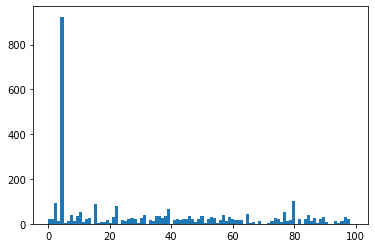

In [26]:
# Histogram of Movies per cluster
#f = pyplot.figure()
plt.hist(tags_cluster, bins=n_clusters);

We note that clusters contain fewer than 200 movies. There is, however, one outlier with over 800 movies. (Note: this is consistent across different clustering methods on this data.)

This outlier is intriguing at the very least. Below we inspect that cluster to better understand its content. 

To start, let us first explore the movies in different clusters. 

In [27]:
#print(tags_cluster[:10])
for i in range(n_clusters):
    idx = np.where(tags_cluster == i)[0]
    print(f'\nCluster {i} (number of movies: {idx.size})')
    idx2 = tags_per_movie.iloc[idx].index
    display(movie_tags_cluster[movie_tags_cluster.mid.isin(idx2)][['mName', 'mGenres']])


Cluster 0 (number of movies: 22)


,mName,mGenres
924,Better Off Dead... (1985),Comedy
957,Some Kind of Wonderful (1987),Drama|Romance
1120,Romy and Michele's High School Reunion (1997),Comedy
1423,"Breakfast Club, The (1985)",Comedy|Drama
1574,Adventures in Babysitting (1987),Adventure|Comedy
1575,Weird Science (1985),Comedy
1585,Sixteen Candles (1984),Comedy
1586,Pretty in Pink (1986),Comedy|Drama|Romance
1660,My Bodyguard (1980),Drama
1665,Say Anything... (1989),Comedy|Drama|Romance



Cluster 1 (number of movies: 23)


,mName,mGenres
643,Singin' in the Rain (1952),Musical|Romance
644,"American in Paris, An (1951)",Musical|Romance
645,Funny Face (1957),Comedy|Musical
651,"Gay Divorcee, The (1934)",Comedy|Musical|Romance
679,"Band Wagon, The (1953)",Comedy|Musical
688,Top Hat (1935),Comedy|Musical|Romance
782,Shall We Dance? (1937),Comedy|Musical|Romance
783,"Damsel in Distress, A (1937)",Comedy|Musical|Romance
860,Strictly Ballroom (1992),Comedy|Romance
1135,Shall We Dance? (Shall We Dansu?) (1996),Comedy



Cluster 2 (number of movies: 91)


,mName,mGenres
87,"Hate (Haine, La) (1995)",Drama
103,Chungking Express (1994),Drama|Mystery|Romance
122,Belle de jour (1967),Drama
171,Before the Rain (Pred dozhdot) (1994),Drama
247,Three Colors: Red (1994),Drama
248,Three Colors: Blue (1993),Drama
249,Three Colors: White (1994),Drama
387,King of the Hill (1993),Drama
428,Short Cuts (1993),Drama
507,Purple Noon (1960),Crime|Thriller



Cluster 3 (number of movies: 14)


,mName,mGenres
243,Queen Margot (La Reine Margot) (1994),Drama|Romance
539,"Horseman on the Roof, The (Hussard sur le toit...",Drama
542,"Visitors, The (Les Visiteurs) (1993)",Comedy|Sci-Fi
828,Jean de Florette (1986),Drama
829,Manon of the Spring (Manon des sources) (1986),Drama
849,Grosse Fatigue (1994),Comedy
916,Nikita (La Femme Nikita) (1990),Thriller
944,Cyrano de Bergerac (1990),Action|Drama|Romance
1020,Ridicule (1996),Drama
2032,"Dinner Game, The (Le D�ner de cons) (1998)",Comedy



Cluster 4 (number of movies: 924)


,mName,mGenres
16,Sense and Sensibility (1995),Drama|Romance
17,Four Rooms (1995),Thriller
20,Get Shorty (1995),Action|Comedy|Drama
23,Powder (1995),Drama|Sci-Fi
24,Leaving Las Vegas (1995),Drama|Romance
27,Persuasion (1995),Romance
29,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
30,Dangerous Minds (1995),Drama
32,Wings of Courage (1995),Adventure|Romance
36,Across the Sea of Time (1995),Documentary



Cluster 5 (number of movies: 4)


,mName,mGenres
131,Desperado (1995),Action|Romance|Thriller
887,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller
1280,"Replacement Killers, The (1998)",Action|Thriller
2477,Hard-Boiled (Lashou shentan) (1992),Action|Crime



Cluster 6 (number of movies: 12)


,mName,mGenres
116,"Basketball Diaries, The (1995)",Drama
574,Trainspotting (1996),Drama
633,Sweet Nothing (1995),Drama
1075,Gridlock'd (1997),Crime
1349,Fear and Loathing in Las Vegas (1998),Comedy|Drama
1680,Permanent Midnight (1998),Drama
1741,Sid and Nancy (1986),Drama
2290,Drugstore Cowboy (1989),Crime|Drama
2484,Bad Lieutenant (1992),Crime|Drama
2771,"Man with the Golden Arm, The (1955)",Drama



Cluster 7 (number of movies: 38)


,mName,mGenres
113,"Birdcage, The (1996)",Comedy
138,Jeffrey (1995),Comedy
144,Love & Human Remains (1993),Comedy
240,Priest (1994),Drama
260,Strawberry and Chocolate (Fresa y chocolate) (...,Drama
262,"Sum of Us, The (1994)",Comedy
279,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
316,Boys Life (1995),Drama
405,Philadelphia (1993),Drama
442,Threesome (1994),Comedy|Romance



Cluster 8 (number of movies: 13)


,mName,mGenres
203,I.Q. (1994),Comedy|Romance
275,While You Were Sleeping (1995),Comedy|Romance
432,Sleepless in Seattle (1993),Comedy|Romance
475,Pretty Woman (1990),Comedy|Romance
534,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
973,When Harry Met Sally... (1989),Comedy|Romance
1153,My Best Friend's Wedding (1997),Comedy|Romance
1284,"Wedding Singer, The (1998)",Comedy|Romance
1569,Ever After: A Cinderella Story (1998),Drama|Romance
1811,You've Got Mail (1998),Comedy|Romance



Cluster 9 (number of movies: 33)


,mName,mGenres
21,Copycat (1995),Crime|Drama|Thriller
81,Nick of Time (1995),Action|Thriller
148,Mute Witness (1994),Thriller
337,Blink (1994),Thriller
368,"Fugitive, The (1993)",Action|Thriller
381,In the Line of Fire (1993),Action|Thriller
604,Ransom (1996),Drama|Thriller
648,Rear Window (1954),Mystery|Thriller
650,Gaslight (1944),Mystery|Thriller
652,North by Northwest (1959),Drama|Thriller



Cluster 10 (number of movies: 54)


,mName,mGenres
52,Georgia (1995),Drama
58,Mr. Holland's Opus (1995),Drama
71,Nico Icon (1995),Documentary
161,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical
200,Immortal Beloved (1994),Drama|Romance
280,Backbeat (1993),Drama|Musical
441,Thirty-Two Short Films About Glenn Gould (1993),Documentary
478,"Great Day in Harlem, A (1994)",Documentary
506,Billy's Holiday (1995),Drama
585,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary



Cluster 11 (number of movies: 10)


,mName,mGenres
33,Babe (1995),Children's|Comedy|Drama
293,"Jungle Book, The (1994)",Adventure|Children's|Romance
366,Free Willy (1993),Adventure|Children's|Drama
460,Andre (1994),Adventure|Children's
738,Homeward Bound: The Incredible Journey (1993),Adventure|Children's
1136,"Second Jungle Book: Mowgli & Baloo, The (1997)",Adventure|Children's
1300,Paulie (1998),Adventure|Children's|Comedy
1369,Doctor Dolittle (1998),Comedy
1576,Doctor Dolittle (1967),Adventure|Musical
1774,Babe: Pig in the City (1998),Children's|Comedy



Cluster 12 (number of movies: 20)


,mName,mGenres
118,Apollo 13 (1995),Drama
228,Murder in the First (1995),Drama|Thriller
382,In the Name of the Father (1993),Drama
420,Rudy (1993),Drama
424,Searching for Bobby Fischer (1993),Drama
1049,Ghosts of Mississippi (1996),Drama
1817,Patch Adams (1998),Comedy|Drama
1819,"Civil Action, A (1998)",Drama
1873,October Sky (1999),Drama
2274,Music of the Heart (1999),Drama



Cluster 13 (number of movies: 26)


,mName,mGenres
177,Circle of Friends (1995),Drama|Romance
253,"Secret of Roan Inish, The (1994)",Drama
338,Blown Away (1994),Action|Thriller
363,Widows' Peak (1994),Drama
518,"Run of the Country, The (1995)",Drama
571,"Last of the High Kings, The (a.k.a. Summer Fli...",Drama
719,Michael Collins (1996),Drama|War
854,Hear My Song (1991),Comedy
895,"Quiet Man, The (1952)",Comedy|Romance
1057,Some Mother's Son (1996),Drama



Cluster 14 (number of movies: 1)


,mName,mGenres
49,"Usual Suspects, The (1995)",Crime|Thriller



Cluster 15 (number of movies: 89)


,mName,mGenres
5,Heat (1995),Action|Crime|Thriller
8,Sudden Death (1995),Action
19,Money Train (1995),Action
22,Assassins (1995),Thriller
65,Fair Game (1995),Action
85,Broken Arrow (1996),Action|Thriller
115,Bad Boys (1995),Action
133,Die Hard: With a Vengeance (1995),Action|Thriller
164,Under Siege 2: Dark Territory (1995),Action
181,Drop Zone (1994),Action



Cluster 16 (number of movies: 4)


,mName,mGenres
870,Aliens (1986),Action|Sci-Fi|Thriller|War
883,Alien (1979),Action|Horror|Sci-Fi|Thriller
920,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
1898,Planet of the Apes (1968),Action|Sci-Fi



Cluster 17 (number of movies: 8)


,mName,mGenres
467,Aladdin (1992),Animation|Children's|Comedy|Musical
472,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
473,Beauty and the Beast (1991),Animation|Children's|Musical
474,Pinocchio (1940),Animation|Children's
745,Cinderella (1950),Animation|Children's|Musical
1526,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
1541,Sleeping Beauty (1959),Animation|Children's|Musical
2854,Make Mine Music (1946),Animation|Children's|Musical



Cluster 18 (number of movies: 10)


,mName,mGenres
624,Bound (1996),Crime|Drama|Romance|Thriller
815,"Funeral, The (1996)",Drama
1664,Married to the Mob (1988),Comedy
1666,My Blue Heaven (1990),Comedy
1907,Analyze This (1999),Comedy
1911,Six Ways to Sunday (1997),Comedy
2117,Mickey Blue Eyes (1999),Comedy|Romance
2520,Ghost Dog: The Way of the Samurai (1999),Crime|Drama
2718,Things Change (1988),Comedy
2778,Prizzi's Honor (1985),Comedy|Drama|Romance



Cluster 19 (number of movies: 15)


,mName,mGenres
149,"Net, The (1995)",Sci-Fi|Thriller
224,Man of the House (1995),Comedy
351,Cops and Robbersons (1994),Comedy
436,Striking Distance (1993),Action
554,Twister (1996),Action|Adventure|Romance|Thriller
607,Chain Reaction (1996),Action|Adventure|Thriller
772,Shadow Conspiracy (1997),Thriller
1062,Murder at 1600 (1997),Mystery|Thriller
1085,Vegas Vacation (1997),Comedy
1677,Nothing But Trouble (1991),Adventure|Comedy



Cluster 20 (number of movies: 4)


,mName,mGenres
1166,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller
1838,"Fly, The (1958)",Horror|Sci-Fi
1839,"Fly, The (1986)",Horror|Sci-Fi
1998,Tarantula (1955),Horror|Sci-Fi



Cluster 21 (number of movies: 29)


,mName,mGenres
636,Land Before Time III: The Time of the Great Gi...,Animation|Children's
942,Highlander (1986),Action|Adventure
981,Amityville 1992: It's About Time (1992),Horror
982,Amityville 3-D (1983),Horror
983,Amityville: Dollhouse (1996),Horror
984,Amityville: A New Generation (1993),Horror
987,"Amityville Curse, The (1990)",Horror
1039,Jaws 3-D (1983),Action|Horror
1107,Turbo: A Power Rangers Movie (1997),Action|Adventure|Children's
1448,Child's Play 3 (1992),Horror



Cluster 22 (number of movies: 79)


,mName,mGenres
35,Dead Man Walking (1995),Drama
39,"Cry, the Beloved Country (1995)",Drama
56,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
111,"Neon Bible, The (1995)",Drama
132,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
154,"Scarlet Letter, The (1995)",Drama
180,Disclosure (1994),Drama|Thriller
188,Exit to Eden (1994),Comedy
194,Hideaway (1995),Thriller
212,"Little Princess, A (1995)",Children's|Drama



Cluster 23 (number of movies: 1)


,mName,mGenres
1499,"Honey, I Blew Up the Kid (1992)",Children's|Comedy|Sci-Fi



Cluster 24 (number of movies: 16)


,mName,mGenres
374,Heaven & Earth (1993),Action|Drama|War
800,Platoon (1986),Drama|War
852,Paths of Glory (1957),Drama|War
877,Apocalypse Now (1979),Drama|War
891,Full Metal Jacket (1987),Action|Drama|War
930,"Deer Hunter, The (1978)",Drama|War
1382,All Quiet on the Western Front (1930),War
1750,Savior (1998),Drama
1813,"Thin Red Line, The (1998)",Action|Drama|War
2009,Pork Chop Hill (1959),War



Cluster 25 (number of movies: 12)


,mName,mGenres
18,Ace Ventura: When Nature Calls (1995),Comedy
60,Bio-Dome (1996),Comedy
173,Billy Madison (1995),Comedy
185,Dumb & Dumber (1994),Comedy
271,Tommy Boy (1995),Comedy
278,Ace Ventura: Pet Detective (1994),Comedy
1506,BASEketball (1998),Comedy
1699,"Night at the Roxbury, A (1998)",Comedy
1730,"Waterboy, The (1998)",Comedy
2391,Deuce Bigalow: Male Gigolo (1999),Comedy



Cluster 26 (number of movies: 23)


,mName,mGenres
267,Star Trek: Generations (1994),Action|Adventure|Sci-Fi
668,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
967,Forbidden Planet (1956),Sci-Fi
1013,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
1024,Star Trek: The Motion Picture (1979),Action|Adventure|Sci-Fi
1025,Star Trek VI: The Undiscovered Country (1991),Action|Adventure|Sci-Fi
1026,Star Trek V: The Final Frontier (1989),Action|Adventure|Sci-Fi
1027,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi
1028,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
1029,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi



Cluster 27 (number of movies: 27)


,mName,mGenres
11,Dracula: Dead and Loving It (1995),Comedy|Horror
59,Don't Be a Menace to South Central While Drink...,Comedy
301,Naked Gun 33 1/3: The Final Insult (1994),Comedy
358,Fatal Instinct (1993),Comedy
375,Hot Shots! Part Deux (1993),Action|Comedy|War
416,Robin Hood: Men in Tights (1993),Comedy
558,Spy Hard (1996),Comedy
605,High School High (1996),Comedy
945,Young Frankenstein (1974),Comedy|Horror
1123,Austin Powers: International Man of Mystery (1...,Comedy



Cluster 28 (number of movies: 22)


,mName,mGenres
95,Braveheart (1995),Action|Drama|War
96,Taxi Driver (1976),Drama|Thriller
649,It Happened One Night (1934),Comedy
670,All About Eve (1950),Drama
812,"Streetcar Named Desire, A (1951)",Drama
897,Raging Bull (1980),Drama
902,"Sting, The (1973)",Comedy|Crime
921,"Treasure of the Sierra Madre, The (1948)",Adventure
933,Unforgiven (1992),Western
943,Cool Hand Luke (1967),Comedy|Drama



Cluster 29 (number of movies: 2)


,mName,mGenres
239,Pulp Fiction (1994),Crime|Drama
799,Reservoir Dogs (1992),Crime|Thriller



Cluster 30 (number of movies: 24)


,mName,mGenres
637,Halloween: The Curse of Michael Myers (1995),Horror|Thriller
1004,"Nightmare on Elm Street, A (1984)",Horror
1053,Scream (1996),Horror|Thriller
1424,Nightmare on Elm Street Part 2: Freddy's Reven...,Horror
1425,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror
1426,"Nightmare on Elm Street 4: The Dream Master, A...",Horror
1427,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror
1429,Friday the 13th (1980),Horror
1430,Friday the 13th Part 2 (1981),Horror
1431,Friday the 13th Part 3: 3D (1982),Horror



Cluster 31 (number of movies: 38)


,mName,mGenres
31,Twelve Monkeys (1995),Drama|Sci-Fi
70,Screamers (1995),Sci-Fi|Thriller
139,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
160,Strange Days (1995),Action|Crime|Sci-Fi
167,Waterworld (1995),Action|Adventure
309,Timecop (1994),Action|Sci-Fi
434,Blade Runner (1982),Film-Noir|Sci-Fi
468,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
759,"Lawnmower Man, The (1992)",Action|Sci-Fi|Thriller
907,"Terminator, The (1984)",Action|Sci-Fi|Thriller



Cluster 32 (number of movies: 1)


,mName,mGenres
869,Brazil (1985),Sci-Fi



Cluster 33 (number of movies: 15)


,mName,mGenres
9,GoldenEye (1995),Action|Adventure|Thriller
1256,Tomorrow Never Dies (1997),Action|Romance|Thriller
1766,"View to a Kill, A (1985)",Action
2234,Goldfinger (1964),Action
2235,From Russia with Love (1963),Action
2236,Dr. No (1962),Action
2267,For Your Eyes Only (1981),Action
2268,Licence to Kill (1989),Action
2269,Live and Let Die (1973),Action
2271,Thunderball (1965),Action



Cluster 34 (number of movies: 13)


,mName,mGenres
26,Now and Then (1995),Drama
37,It Takes Two (1995),Comedy
1033,Grease (1978),Comedy|Musical|Romance
1162,G.I. Jane (1997),Action|Drama|War
1259,"Horse Whisperer, The (1998)",Drama
1353,Hope Floats (1998),Comedy|Drama|Romance
1610,"Strike! (a.k.a. All I Wanna Do, The Hairy Bird...",Comedy
1663,Working Girl (1988),Comedy|Drama
2258,Three to Tango (1999),Comedy|Romance
2422,"Girl, Interrupted (1999)",Drama



Cluster 35 (number of movies: 37)


,mName,mGenres
25,Othello (1995),Drama
40,Richard III (1995),Drama|War
86,In the Bleak Midwinter (1995),Comedy
390,M. Butterfly (1993),Drama
398,Much Ado About Nothing (1993),Comedy|Romance
431,Six Degrees of Separation (1993),Drama
594,American Buffalo (1996),Drama
638,Twelfth Night (1996),Comedy|Drama|Romance
710,Cat on a Hot Tin Roof (1958),Drama
768,Looking for Richard (1996),Documentary|Drama



Cluster 36 (number of movies: 36)


,mName,mGenres
707,Night of the Living Dead (1968),Horror|Sci-Fi
825,"Fog, The (1980)",Horror
925,"Shining, The (1980)",Horror
986,"Amityville Horror, The (1979)",Horror
999,Candyman (1992),Horror
1002,Carrie (1976),Horror
1007,"Omen, The (1976)",Horror
1446,Child's Play (1988),Horror
1449,Poltergeist (1982),Horror|Thriller
1452,"Exorcist, The (1973)",Horror



Cluster 37 (number of movies: 24)


,mName,mGenres
50,Mighty Aphrodite (1995),Comedy
383,What's Love Got to Do with It? (1993),Drama
406,"Piano, The (1993)",Drama|Romance
482,Fargo (1996),Crime|Drama|Thriller
642,"Philadelphia Story, The (1940)",Comedy|Romance
806,Sophie's Choice (1982),Drama
821,On Golden Pond (1981),Drama
847,Cinema Paradiso (1988),Comedy|Drama|Romance
1387,"Great Ziegfeld, The (1936)",Musical
1419,Klute (1971),Drama|Mystery



Cluster 38 (number of movies: 36)


,mName,mGenres
1,Jumanji (1995),Adventure|Children's|Fantasy
7,Tom and Huck (1995),Adventure|Children's
14,Cutthroat Island (1995),Action|Adventure|Romance
128,Congo (1995),Action|Adventure|Mystery|Sci-Fi
136,Free Willy 2: The Adventure Home (1995),Adventure|Children's|Drama
384,Jurassic Park (1993),Action|Adventure|Sci-Fi
444,"Three Musketeers, The (1993)",Action|Adventure|Comedy
448,"Pagemaster, The (1994)",Action|Adventure|Animation|Children's|Fantasy
566,Kim (1950),Children's|Drama
683,"Adventures of Robin Hood, The (1938)",Action|Adventure



Cluster 39 (number of movies: 65)


,mName,mGenres
143,Lord of Illusions (1995),Horror
176,Castle Freak (1995),Horror
266,Tales From the Crypt Presents: Demon Knight (1...,Horror
268,Tales from the Hood (1995),Comedy|Horror
297,Wes Craven's New Nightmare (1994),Horror
312,Wolf (1994),Drama|Horror
321,"Fear, The (1995)",Horror
324,In the Mouth of Madness (1995),Horror|Thriller
485,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi
557,Thinner (1996),Horror|Thriller



Cluster 40 (number of movies: 1)


,mName,mGenres
1863,Simply Irresistible (1999),Comedy|Romance



Cluster 41 (number of movies: 15)


,mName,mGenres
79,Dunston Checks In (1996),Children's|Comedy
595,Alaska (1996),Adventure|Children's
733,"Love Bug, The (1969)",Children's|Comedy
1160,"Simple Wish, A (1997)",Children's|Fantasy
1252,Mouse Hunt (1997),Children's|Comedy
1485,Blank Check (1994),Children's|Comedy
1496,Herbie Goes Bananas (1980),Adventure|Children's|Comedy
1522,"Journey of Natty Gann, The (1985)",Adventure|Children's
1697,Antz (1998),Animation|Children's
1748,"Bug's Life, A (1998)",Animation|Children's|Comedy



Cluster 42 (number of movies: 21)


,mName,mGenres
38,Clueless (1995),Comedy|Romance
354,Dazed and Confused (1993),Comedy
527,Angus (1995),Comedy
545,"Craft, The (1996)",Drama|Horror
811,Rebel Without a Cause (1955),Drama
935,Pump Up the Volume (1990),Drama
952,Heathers (1989),Comedy
1359,Can't Hardly Wait (1998),Comedy|Drama|Romance
1477,Disturbing Behavior (1998),Horror|Thriller
1831,Varsity Blues (1999),Comedy|Drama



Cluster 43 (number of movies: 17)


,mName,mGenres
502,Mission: Impossible (1996),Action|Adventure|Mystery
673,Foreign Correspondent (1940),Thriller
674,Notorious (1946),Film-Noir|Romance|Thriller
704,"39 Steps, The (1935)",Thriller
1045,Sneakers (1992),Crime|Drama|Sci-Fi
1098,"Saint, The (1997)",Action|Romance|Thriller
1180,"Hunt for Red October, The (1990)",Action|Thriller
1196,"Assignment, The (1997)",Thriller
1617,Topaz (1969),Thriller
1643,"Lady Vanishes, The (1938)",Comedy|Mystery|Romance|Thriller



Cluster 44 (number of movies: 20)


,mName,mGenres
63,Friday (1995),Comedy
80,Black Sheep (1996),Comedy
217,Major Payne (1994),Comedy
361,Fear of a Black Hat (1993),Comedy
544,Wallace & Gromit: The Best of Aardman Animatio...,Animation
790,"Fish Called Wanda, A (1988)",Comedy
1067,Beverly Hills Ninja (1997),Action|Comedy
1090,Booty Call (1997),Comedy|Romance
1200,How to Be a Player (1997),Comedy
1631,Dirty Work (1998),Comedy



Cluster 45 (number of movies: 22)


,mName,mGenres
989,April Fool's Day (1986),Comedy|Horror
1204,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller
1428,Freddy's Dead: The Final Nightmare (1991),Horror
1439,Halloween III: Season of the Witch (1983),Horror
1442,Prom Night (1980),Horror
1443,Hello Mary Lou: Prom Night II (1987),Horror
1444,Prom Night III: The Last Kiss (1989),Horror
1445,Prom Night IV: Deliver Us From Evil (1992),Horror
1551,Halloween: H20 (1998),Horror|Thriller
1714,Bride of Chucky (1998),Horror|Thriller



Cluster 46 (number of movies: 33)


,mName,mGenres
158,Species (1995),Horror|Sci-Fi
255,Stargate (1994),Action|Adventure|Sci-Fi
408,Robert A. Heinlein's The Puppet Masters (1994),Horror|Sci-Fi
562,"Arrival, The (1996)",Action|Sci-Fi|Thriller
576,Independence Day (ID4) (1996),Action|Sci-Fi|War
824,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
979,Alien� (1992),Action|Horror|Sci-Fi|Thriller
1041,Mars Attacks! (1996),Action|Comedy|Sci-Fi|War
1158,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
1161,Contact (1997),Drama|Sci-Fi



Cluster 47 (number of movies: 21)


,mName,mGenres
162,Three Wishes (1995),Drama
192,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children's
195,Fluke (1995),Children's|Drama
388,Lassie (1994),Adventure|Children's
483,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children's
735,Old Yeller (1957),Children's|Drama
739,"Shaggy Dog, The (1959)",Children's|Comedy
1021,101 Dalmatians (1996),Children's|Comedy
1064,Zeus and Roxanne (1997),Children's
1143,Shiloh (1997),Children's|Drama



Cluster 48 (number of movies: 9)


,mName,mGenres
28,"City of Lost Children, The (1995)",Adventure|Sci-Fi
549,"Institute Benjamenta, or This Dream People Cal...",Drama
1087,Lost Highway (1997),Mystery
1521,Blue Velvet (1986),Drama|Mystery
1867,"Fantastic Planet, The (La Plan�te sauvage) (1973)",Animation|Sci-Fi
2275,Being John Malkovich (1999),Comedy
2432,Even Dwarfs Started Small (Auch Zwerge haben k...,Drama
2474,Twin Peaks: Fire Walk with Me (1992),Drama|Mystery
2769,Eraserhead (1977),Drama|Horror



Cluster 49 (number of movies: 23)


,mName,mGenres
43,Mortal Kombat (1995),Action|Adventure
97,Rumble in the Bronx (1995),Action|Adventure|Crime
319,Street Fighter (1994),Action
511,Bloodsport 2 (1995),Action
530,"Quest, The (1996)",Action|Adventure
623,Supercop (1992),Action|Thriller
712,In the Line of Duty 2 (1987),Action
1065,Jackie Chan's First Strike (1996),Action
1109,Double Team (1997),Action
1235,Mortal Kombat: Annihilation (1997),Action|Adventure



Cluster 50 (number of movies: 36)


,mName,mGenres
169,Wild Bill (1995),Western
244,"Quick and the Dead, The (1995)",Action|Adventure|Western
313,Wyatt Earp (1994),Western
445,Tombstone (1993),Western
477,"Wild Bunch, The (1969)",Western
538,Dead Man (1995),Western
703,Angel and the Badman (1947),Western
706,"Outlaw, The (1943)",Western
855,"Shooter, The (1995)",Action
871,"Good, The Bad and The Ugly, The (1966)",Action|Western



Cluster 51 (number of movies: 3)


,mName,mGenres
210,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
866,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
879,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War



Cluster 52 (number of movies: 22)


,mName,mGenres
0,Toy Story (1995),Animation|Children's|Comedy
12,Balto (1995),Animation|Children's
295,"Lion King, The (1994)",Animation|Children's|Musical
487,"Aristocats, The (1970)",Animation|Children's
535,Oliver & Company (1988),Animation|Children's
748,"Sword in the Stone, The (1963)",Animation|Children's
752,Dumbo (1941),Animation|Children's|Musical
755,Alice in Wonderland (1951),Animation|Children's|Musical
756,"Fox and the Hound, The (1981)",Animation|Children's
1366,Mulan (1998),Animation|Children's



Cluster 53 (number of movies: 32)


,mName,mGenres
259,Suture (1993),Film-Noir|Thriller
647,Vertigo (1958),Mystery|Thriller
655,Charade (1963),Comedy|Mystery|Romance|Thriller
675,Spellbound (1945),Mystery|Romance|Thriller
677,To Catch a Thief (1955),Comedy|Romance|Thriller
991,"Birds, The (1963)",Horror
1296,Hush (1998),Thriller
1356,"Perfect Murder, A (1998)",Mystery|Thriller
1468,"Apple Dumpling Gang Rides Again, The (1979)",Children's|Comedy|Western
1615,Family Plot (1976),Comedy|Thriller



Cluster 54 (number of movies: 27)


,mName,mGenres
568,Stalingrad (1993),War
639,Mother Night (1996),Drama
656,Casablanca (1942),Drama|Romance|War
901,"Boat, The (Das Boot) (1981)",Action|Drama|War
917,"Bridge on the River Kwai, The (1957)",Drama|War
929,"Great Escape, The (1963)",Adventure|War
939,Patton (1970),Drama|War
1391,Mrs. Miniver (1942),Drama|War
1479,Saving Private Ryan (1998),Action|Drama|War
1821,Tea with Mussolini (1999),Comedy



Cluster 55 (number of movies: 3)


,mName,mGenres
621,"Godfather, The (1972)",Action|Crime|Drama
890,"Godfather: Part II, The (1974)",Action|Crime|Drama
1630,"Untouchables, The (1987)",Action|Crime|Drama



Cluster 56 (number of movies: 19)


,mName,mGenres
13,Nixon (1995),Drama
88,City Hall (1996),Drama|Thriller
353,Dave (1993),Comedy|Romance
447,"War Room, The (1993)",Documentary
697,Mr. Smith Goes to Washington (1939),Drama
793,"Candidate, The (1972)",Drama
820,"Perfect Candidate, A (1996)",Documentary
846,Bob Roberts (1992),Comedy
1040,My Fellow Americans (1996),Comedy
1271,Wag the Dog (1997),Comedy|Drama



Cluster 57 (number of movies: 40)


,mName,mGenres
51,"Big Green, The (1995)",Children's|Comedy
198,Hoop Dreams (1994),Documentary
287,Cobb (1994),Drama
325,Above the Rim (1994),Drama
330,"Air Up There, The (1994)",Comedy
339,Blue Chips (1994),Drama
407,"Program, The (1993)",Action|Drama
423,"Scout, The (1994)",Drama
456,Little Big League (1994),Children's|Comedy
505,Eddie (1996),Comedy



Cluster 58 (number of movies: 13)


,mName,mGenres
121,Batman Forever (1995),Action|Adventure|Comedy|Crime
426,"Shadow, The (1994)",Action
470,Batman (1989),Action|Adventure|Crime|Drama
1030,Batman Returns (1992),Action|Adventure|Comedy|Crime
1149,Batman & Robin (1997),Action|Adventure|Crime
1173,Steel (1997),Action
1489,Condorman (1981),Action|Adventure|Children's|Comedy
1984,Superman II (1980),Action|Adventure|Sci-Fi
1985,Superman III (1983),Action|Adventure|Sci-Fi
2056,Mystery Men (1999),Action|Adventure|Comedy



Cluster 59 (number of movies: 32)


,mName,mGenres
47,Pocahontas (1995),Animation|Children's|Musical|Romance
193,"Goofy Movie, A (1995)",Animation|Children's|Comedy|Romance
252,"Swan Princess, The (1994)",Animation|Children's
515,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy
579,"Hunchback of Notre Dame, The (1996)",Animation|Children's|Musical
746,Winnie the Pooh and the Blustery Day (1968),Animation|Children's
747,"Three Caballeros, The (1945)",Animation|Children's|Musical
749,So Dear to My Heart (1949),Children's|Drama
753,Pete's Dragon (1977),Adventure|Animation|Children's|Musical
949,Fantasia (1940),Animation|Children's|Musical



Cluster 60 (number of movies: 20)


,mName,mGenres
6,Sabrina (1995),Comedy|Romance
101,If Lucy Fell (1996),Comedy|Romance
191,Forget Paris (1995),Comedy|Romance
292,It Could Happen to You (1994),Drama|Romance
364,For Love or Money (1993),Comedy
480,One Fine Day (1996),Drama|Romance
575,'Til There Was You (1997),Drama|Romance
659,Sabrina (1954),Comedy|Romance
660,Roman Holiday (1953),Comedy|Romance
1071,Benny & Joon (1993),Comedy|Romance



Cluster 61 (number of movies: 16)


,mName,mGenres
99,Anne Frank Remembered (1995),Documentary
422,Schindler's List (1993),Drama|War
689,To Be or Not to Be (1942),Comedy|Drama|War
948,"Great Dictator, The (1940)",Comedy
1247,Bent (1997),Drama|War
1550,Swing Kids (1993),Drama|War
1717,Apt Pupil (1998),Drama|Thriller
1720,Life Is Beautiful (La Vita � bella) (1997),Comedy|Drama
1865,"Harmonists, The (1997)",Drama
1866,"Last Days, The (1998)",Documentary



Cluster 62 (number of movies: 18)


,mName,mGenres
504,Dragonheart (1996),Action|Adventure|Fantasy
663,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
867,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
1163,Conan the Barbarian (1982),Action|Adventure
1422,Labyrinth (1986),Adventure|Children's|Fantasy
1482,"Black Cauldron, The (1985)",Animation|Children's
1581,"Dark Crystal, The (1982)",Children's|Fantasy|Sci-Fi
1584,Legend (1985),Adventure|Fantasy|Romance
1599,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy
1600,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy



Cluster 63 (number of movies: 18)


,mName,mGenres
83,Vampire in Brooklyn (1995),Comedy|Romance
120,"Addiction, The (1995)",Horror
204,Interview with the Vampire (1994),Drama|Horror
454,Cronos (1992),Horror
612,Tales from the Crypt Presents: Bordello of Blo...,Horror
996,Bram Stoker's Dracula (1992),Horror|Romance
1005,"Nosferatu (Nosferatu, eine Symphonie des Graue...",Horror
1006,Nosferatu a Venezia (1986),Horror
1282,Night Flier (1997),Horror
1723,Vampires (1998),Horror



Cluster 64 (number of movies: 1)


,mName,mGenres
858,My Left Foot (1989),Drama



Cluster 65 (number of movies: 45)


,mName,mGenres
10,"American President, The (1995)",Comedy|Drama|Romance
68,Bed of Roses (1996),Drama|Romance
92,"Bridges of Madison County, The (1995)",Drama|Romance
112,Up Close and Personal (1996),Drama|Romance
166,"Walk in the Clouds, A (1995)",Drama|Romance
172,Before Sunrise (1995),Drama|Romance
179,Don Juan DeMarco (1995),Comedy|Drama|Romance
190,French Kiss (1995),Comedy|Romance
220,Love Affair (1994),Drama|Romance
234,Only You (1994),Comedy|Romance



Cluster 66 (number of movies: 2)


,mName,mGenres
868,Raiders of the Lost Ark (1981),Action|Adventure
958,Indiana Jones and the Last Crusade (1989),Action|Adventure



Cluster 67 (number of movies: 6)


,mName,mGenres
657,"Maltese Falcon, The (1941)",Film-Noir|Mystery
685,Laura (1944),Crime|Film-Noir|Mystery
785,"Murder, My Sweet (1944)",Film-Noir|Thriller
919,Chinatown (1974),Film-Noir|Mystery|Thriller
951,"Big Sleep, The (1946)",Film-Noir|Mystery
2589,Double Indemnity (1944),Crime|Film-Noir



Cluster 68 (number of movies: 1)


,mName,mGenres
257,"Shawshank Redemption, The (1994)",Drama



Cluster 69 (number of movies: 14)


,mName,mGenres
150,Nine Months (1995),Comedy
290,Four Weddings and a Funeral (1994),Comedy|Romance
498,Jack and Sarah (1995),Romance
523,Mrs. Winterbourne (1996),Comedy|Romance
1086,That Old Feeling (1997),Comedy|Romance
1169,Picture Perfect (1997),Comedy|Romance
1234,Sliding Doors (1998),Drama|Romance
1326,Kissing a Fool (1998),Comedy|Romance
1594,How Stella Got Her Groove Back (1998),Drama|Romance
1868,Blast from the Past (1999),Comedy|Romance



Cluster 70 (number of movies: 1)


,mName,mGenres
1377,Pi (1998),Sci-Fi|Thriller



Cluster 71 (number of movies: 1)


,mName,mGenres
2242,Fight Club (1999),Drama



Cluster 72 (number of movies: 5)


,mName,mGenres
559,"Close Shave, A (1995)",Animation|Comedy|Thriller
833,"Wrong Trousers, The (1993)",Animation|Comedy
892,"Grand Day Out, A (1992)",Animation|Comedy
2583,Creature Comforts (1990),Animation|Comedy
2832,Chicken Run (2000),Animation|Children's|Comedy



Cluster 73 (number of movies: 11)


,mName,mGenres
91,Happy Gilmore (1996),Comedy
581,Kingpin (1996),Comedy
791,Monty Python's Life of Brian (1979),Comedy
831,Monty Python and the Holy Grail (1974),Comedy
865,Up in Smoke (1978),Comedy
955,This Is Spinal Tap (1984),Comedy|Drama|Musical
1274,Half Baked (1998),Comedy
1379,There's Something About Mary (1998),Comedy
2035,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy
2833,"Me, Myself and Irene (2000)",Comedy



Cluster 74 (number of movies: 26)


,mName,mGenres
304,Red Rock West (1992),Thriller
417,Romeo Is Bleeding (1993),Crime|Thriller
693,"Thin Man, The (1934)",Mystery
784,Crossfire (1947),Crime|Film-Noir
837,He Walked by Night (1948),Crime|Film-Noir|Thriller
853,"Grifters, The (1990)",Crime|Drama|Film-Noir
861,"Thin Blue Line, The (1988)",Documentary
1018,Paradise Lost: The Child Murders at Robin Hood...,Documentary
1083,Absolute Power (1997),Mystery|Thriller
1165,Cop Land (1997),Crime|Drama|Mystery



Cluster 75 (number of movies: 20)


,mName,mGenres
227,Miracle on 34th Street (1994),Drama
270,Village of the Damned (1995),Horror|Sci-Fi
340,Body Snatchers (1993),Horror|Sci-Fi|Thriller
370,"Getaway, The (1994)",Action
499,Diabolique (1996),Drama|Thriller
721,Last Man Standing (1996),Action|Drama|Western
1000,Cape Fear (1991),Thriller
1003,Cat People (1982),Horror
1084,That Darn Cat! (1997),Children's|Comedy|Mystery
1240,"Jackal, The (1997)",Action|Thriller



Cluster 76 (number of movies: 6)


,mName,mGenres
64,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
908,Braindead (1992),Comedy|Horror
922,Bad Taste (1987),Comedy|Horror
928,Evil Dead II (Dead By Dawn) (1987),Action|Adventure|Comedy|Horror
2532,Blood Feast (1963),Horror
2967,Hellraiser (1987),Horror



Cluster 77 (number of movies: 51)


,mName,mGenres
2,Grumpier Old Men (1995),Comedy|Romance
4,Father of the Bride Part II (1995),Comedy
322,Highlander III: The Sorcerer (1994),Action|Sci-Fi
326,Addams Family Values (1993),Comedy
346,City Slickers II: The Legend of Curly's Gold (...,Comedy|Western
415,Robocop 3 (1993),Sci-Fi|Thriller
481,Candyman: Farewell to the Flesh (1995),Horror
494,All Dogs Go to Heaven 2 (1996),Animation|Children's|Musical
598,"Very Brady Sequel, A (1996)",Comedy
610,"Crow: City of Angels, The (1996)",Action|Thriller



Cluster 78 (number of movies: 12)


,mName,mGenres
46,Seven (Se7en) (1995),Crime|Thriller
493,Primal Fear (1996),Drama|Thriller
1193,"Game, The (1997)",Mystery|Thriller
1275,Fallen (1998),Action|Mystery|Thriller
1297,Suicide Kings (1997),Crime|Drama
1299,Wild Things (1998),Crime|Drama|Mystery|Thriller
1317,"Spanish Prisoner, The (1997)",Drama|Thriller
1938,Following (1998),Drama
1946,Open Your Eyes (Abre los ojos) (1997),Drama|Romance|Sci-Fi
2041,Arlington Road (1999),Thriller



Cluster 79 (number of movies: 19)


,mName,mGenres
666,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
667,Citizen Kane (1941),Drama
672,Rebecca (1940),Romance|Thriller
881,"Third Man, The (1949)",Mystery|Thriller
886,Ran (1985),Drama|War
915,Touch of Evil (1958),Crime|Film-Noir|Thriller
927,M (1931),Crime|Film-Noir|Thriller
1470,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
1512,Out of the Past (1947),Film-Noir
1712,"Elephant Man, The (1980)",Drama



Cluster 80 (number of movies: 103)


,mName,mGenres
108,Down Periscope (1996),Comedy
145,Mallrats (1995),Comedy
178,Clerks (1994),Comedy
206,"Jerky Boys, The (1994)",Comedy
207,Junior (1994),Comedy|Sci-Fi
263,National Lampoon's Senior Trip (1995),Comedy
298,"Mask, The (1994)",Comedy|Crime|Fantasy
299,Maverick (1994),Action|Comedy|Western
329,Airheads (1994),Comedy
347,Clean Slate (1994),Comedy



Cluster 81 (number of movies: 1)


,mName,mGenres
1250,Good Will Hunting (1997),Drama



Cluster 82 (number of movies: 21)


,mName,mGenres
42,Restoration (1995),Drama
222,"Madness of King George, The (1994)",Drama
369,Geronimo: An American Legend (1993),Drama|Western
731,"Davy Crockett, King of the Wild Frontier (1955)",Western
899,"Right Stuff, The (1983)",Drama
909,Glory (1989),Action|Drama|War
960,Gandhi (1982),Drama
965,"Killing Fields, The (1984)",Drama|War
1244,Amistad (1997),Drama
1386,Mutiny on the Bounty (1935),Adventure



Cluster 83 (number of movies: 1)


,mName,mGenres
1972,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi



Cluster 84 (number of movies: 23)


,mName,mGenres
134,"Doom Generation, The (1995)",Comedy|Drama
443,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical
510,Underground (1995),War
564,Careful (1992),Comedy
836,Faust (1994),Animation|Comedy|Thriller
840,"Tin Drum, The (Blechtrommel, Die) (1979)",Drama
850,Delicatessen (1991),Comedy|Sci-Fi
1130,Nowhere (1997),Drama
1154,Tetsuo II: Body Hammer (1992),Sci-Fi
1552,L.A. Story (1991),Comedy|Romance



Cluster 85 (number of movies: 41)


,mName,mGenres
34,Carrington (1995),Drama|Romance
84,Beautiful Girls (1996),Drama
114,"Brothers McMullen, The (1995)",Comedy
147,Moonlight and Valentino (1995),Drama|Romance
186,Eat Drink Man Woman (1994),Comedy|Drama
490,My Favorite Season (1993),Drama
522,It's My Party (1995),Drama
577,Stealing Beauty (1996),Drama
591,Walking and Talking (1996),Romance
592,She's the One (1996),Comedy|Romance



Cluster 86 (number of movies: 11)


,mName,mGenres
233,Natural Born Killers (1994),Action|Thriller
235,Once Were Warriors (1994),Crime|Drama
394,Menace II Society (1993),Action|Crime|Drama
418,Romper Stomper (1992),Action|Drama
446,True Romance (1993),Action|Crime|Romance
875,"Clockwork Orange, A (1971)",Sci-Fi
882,GoodFellas (1990),Crime|Drama
1261,Jackie Brown (1997),Crime|Drama
1597,Henry: Portrait of a Serial Killer (1990),Crime|Horror
1724,American History X (1998),Drama



Cluster 87 (number of movies: 28)


,mName,mGenres
469,Dances with Wolves (1990),Adventure|Drama|Western
653,"Apartment, The (1960)",Comedy|Drama
658,My Fair Lady (1964),Musical|Romance
664,Gone with the Wind (1939),Drama|Romance|War
691,Giant (1956),Drama
695,Around the World in 80 Days (1956),Adventure|Comedy
757,"Sound of Music, The (1965)",Musical
874,Lawrence of Arabia (1962),Adventure|War
898,Annie Hall (1977),Comedy|Romance
954,Ben-Hur (1959),Action|Adventure|Drama



Cluster 88 (number of movies: 5)


,mName,mGenres
471,"Silence of the Lambs, The (1991)",Drama|Thriller
864,One Flew Over the Cuckoo's Nest (1975),Drama
894,Amadeus (1984),Drama
1288,As Good As It Gets (1997),Comedy|Drama
1416,Rain Man (1988),Drama



Cluster 89 (number of movies: 23)


,mName,mGenres
3,Waiting to Exhale (1995),Comedy|Drama
45,How to Make an American Quilt (1995),Drama|Romance
75,Antonia's Line (Antonia) (1995),Drama
174,Boys on the Side (1995),Comedy|Drama
332,Bad Girls (1994),Western
371,Go Fish (1994),Drama|Romance
376,Live Nude Girls (1995),Comedy
602,"First Wives Club, The (1996)",Comedy
671,"Women, The (1939)",Comedy
723,Set It Off (1996),Action|Crime



Cluster 90 (number of movies: 29)


,mName,mGenres
107,Jade (1995),Thriller
156,Showgirls (1995),Drama
236,Poison Ivy II (1995),Thriller
281,Bitter Moon (1992),Drama
341,Boxing Helena (1993),Mystery|Romance|Thriller
350,Color of Night (1994),Drama|Thriller
396,In the Realm of the Senses (Ai no corrida) (1976),Drama
430,Sirens (1994),Comedy|Drama
433,Sliver (1993),Thriller
449,"Paris, France (1993)",Comedy



Cluster 91 (number of movies: 9)


,mName,mGenres
140,Judge Dredd (1995),Action|Adventure|Sci-Fi
569,"Phantom, The (1996)",Adventure
1167,Spawn (1997),Action|Adventure|Sci-Fi|Thriller
1605,Blade (1998),Action|Adventure|Horror
1962,Dick Tracy (1990),Action|Crime
1983,Superman (1978),Action|Adventure|Sci-Fi
2008,Swamp Thing (1982),Horror|Sci-Fi
2592,Teenage Mutant Ninja Turtles (1990),Action|Children's|Fantasy
2870,X-Men (2000),Action|Sci-Fi



Cluster 92 (number of movies: 1)


,mName,mGenres
1932,"Matrix, The (1999)",Action|Sci-Fi|Thriller



Cluster 93 (number of movies: 1)


,mName,mGenres
289,Forrest Gump (1994),Comedy|Romance|War



Cluster 94 (number of movies: 14)


,mName,mGenres
365,"Firm, The (1993)",Drama|Thriller
593,"Time to Kill, A (1996)",Drama
873,12 Angry Men (1957),Drama
1145,Trial and Error (1997),Comedy|Romance
1226,"Rainmaker, The (1997)",Drama
1679,"Few Good Men, A (1992)",Crime|Drama
1704,My Cousin Vinny (1992),Comedy
2115,"Pelican Brief, The (1993)",Thriller
2330,"Verdict, The (1982)",Drama
2358,Jagged Edge (1985),Thriller



Cluster 95 (number of movies: 2)


,mName,mGenres
611,Eyes Without a Face (1959),Horror
2289,Re-Animator (1985),Horror



Cluster 96 (number of movies: 14)


,mName,mGenres
15,Casino (1995),Drama|Thriller
74,Things to Do in Denver when You're Dead (1995),Crime|Drama|Romance
282,Bullets Over Broadway (1994),Comedy
342,"Bronx Tale, A (1993)",Drama
345,Carlito's Way (1993),Crime|Drama
795,Bonnie and Clyde (1967),Crime|Drama
896,Once Upon a Time in America (1984),Crime|Drama|Thriller
912,Miller's Crossing (1990),Drama
1089,Donnie Brasco (1997),Crime|Drama
1174,Hoodlum (1997),Crime|Drama|Film-Noir



Cluster 97 (number of movies: 30)


,mName,mGenres
163,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
229,Nobody's Fool (1994),Drama
273,What's Eating Gilbert Grape (1993),Drama
565,Gold Diggers: The Secret of Bear Mountain (1995),Adventure|Children's
589,Lone Star (1996),Drama|Mystery
614,"Spitfire Grill, The (1996)",Drama
696,It's a Wonderful Life (1946),Drama
713,Picnic (1955),Drama
737,Pollyanna (1960),Children's|Comedy|Drama
906,Local Hero (1983),Comedy



Cluster 98 (number of movies: 23)


,mName,mGenres
317,Faster Pussycat! Kill! Kill! (1965),Action|Comedy|Drama
516,Barbarella (1968),Adventure|Sci-Fi
553,Cemetery Man (Dellamorte Dellamore) (1994),Comedy|Horror
872,Withnail and I (1987),Comedy
884,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi
903,Harold and Maude (1971),Comedy
963,Real Genius (1985),Comedy
1264,"Big Lebowski, The (1998)",Comedy|Crime|Mystery|Thriller
1380,Plan 9 from Outer Space (1958),Horror|Sci-Fi
1420,Repo Man (1984),Comedy|Sci-Fi



Cluster 99 (number of movies: 1)


,mName,mGenres
1400,On the Waterfront (1954),Crime|Drama


Above we note that the clusters seem to "make sense". If you know some of these movies it will be clear that clusters are coherent. If not, then the genre column is a reasonable proxy (i.e., that clusters tend to have fairly homogeneous genres).  

Now, what about that very large cluster. Let us examine it to understand how it came about. 

In [28]:
large_cluster_id = np.argmax(np.bincount(tags_cluster))
idx = np.where(tags_cluster == large_cluster_id)[0]

idx2 = movie_tags_cluster.iloc[idx].mid
display(tags_high_names_movies[tags_high_names_movies.mid.isin(idx2)].sort_values(by=['mid']))

,mid,tid,relevance,tName,mName,mGenres
8224,17,259,0.96750,costume drama,Sense and Sensibility (1995),Drama|Romance
8227,17,774,0.96625,period piece,Sense and Sensibility (1995),Drama|Romance
8226,17,606,0.91825,literature,Sense and Sensibility (1995),Drama|Romance
8225,17,574,0.93450,jane austen,Sense and Sensibility (1995),Drama|Romance
8220,17,864,0.95250,romantic,Sense and Sensibility (1995),Drama|Romance
8221,17,3,0.98000,18th century,Sense and Sensibility (1995),Drama|Romance
8222,17,10,0.92625,19th century,Sense and Sensibility (1995),Drama|Romance
8223,17,22,0.97300,adapted from:book,Sense and Sensibility (1995),Drama|Romance
11050,18,972,0.91200,storytelling,Four Rooms (1995),Thriller
11049,18,735,0.92675,off-beat comedy,Four Rooms (1995),Thriller


This list does not provide much clarity but confirms that the movies in this cluster do not seem to belong. 

One possibility is that we just don't have enough tag information about these movies to cluster them accurately. Below we show that movies receive an average of 5.3 tags, movies in this cluster only receive an average of 2.4 tags.

Furthermore, the tags in this cluster seem to be slightly more popular (17.4 movies) than the average tag (16.3 movies). So that does not seem to be a factor.

In [29]:
# look at average number of tags of movies in this cluster versus in other clusters
print('Average number of tags for movies from the last cluster %.2f' % 
      tags_high_names_movies[tags_high_names_movies.mid.isin(idx2)].groupby('mid').count().mean()[0])
print('Average number of tags for all movies %.2f' %
      tags_high_names_movies.groupby('mid').count().mean()[0])

print()
# examine the tags themselves. Are they rare tags? 
print('Average number of movies for tags in the large cluster %.2f' %
      tags_high_names_movies[tags_high_names_movies.tid.isin(idx2)].groupby('tid').count().mean()[0])
print('Average number of movies for all tags %.2f' %
      tags_high_names_movies.groupby('tid').count().mean()[0])

Average number of tags for movies from the last cluster 2.46
Average number of tags for all movies 5.26

Average number of movies for tags in the large cluster 17.00
Average number of movies for all tags 16.29


#### Clustering remarks

- Above we ran a clustering method to cluster movies according to their tags. 
- We noticed that while most movies were reasonably clustered, a reasonably large number of movies belonged to a single (large) cluster. 
- Recall that movie tag representations are very sparse vectors. As such, two movies with a small number of tags may actually be close to one another according to most metrics. 

##### Question 2

- What would you suggest to obtain better clusters? 


In [30]:
# we save this result for later by adding the clustering results to our main dataFrame
tags_per_movie['tcluster'] = tags_cluster

### Prepare dataset

In the next few steps we further pre-process our data in order to create a dataset for supervised learning. Recall, that we wish to predict user-movie preferences from user and movie features. 

In [31]:
# Join users, ratings, and tags
data_pd = pd.merge(users_pd, ratings_pd, how='inner', on='uid')
data_pd = pd.merge(data_pd, tags_per_movie, how='inner', on='mid')

Final descriptive stats of our dataset.
	- 2998 items
	- 6040 users
	- 962760 ratings


For the purpose of this tutorial, we will only use a small fraction of our dataset to ensure that all operations (and especially model fitting) can be done in a matter of minutes.

In [32]:
# shuffle data and keep 2% of the ratings.
# (this small percentage ensures that all computations in this tutorial are fast)
data_pd = data_pd.sample(frac=0.02, random_state=1234)
print(data_pd.shape)

(19255, 979)


We can have a look at our current dataset.

In [57]:
print('Final descriptive stats of our dataset.')
print('\t- %d items'   % data_pd['mid'].nunique())
print('\t- %d users'   % data_pd['uid'].nunique())
print('\t- %d ratings' % data_pd.shape[0])

Final descriptive stats of our dataset.
	- 2403 items
	- 4656 users
	- 19255 ratings


Notice that we have several categorical variables (e.g., gender, occupation, zip, mid). Below, we transform these using dummy variables (just like we did above for tags for clustering).

In [33]:
print(data_pd.shape)
display(data_pd[:10])

(19255, 979)


,uid,gender,age,occupation,zip,mid,rating,timestamp,index,relevance,...,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128,tcluster
903131,2907,F,35,5,12,1460,3,972180633,1464992,0.92650,...,0,0,0,0,0,0,0,0,0,75
601683,355,M,18,3,55,1644,2,977033178,9771710,5.76650,...,0,0,0,0,0,0,0,0,0,45
776794,3471,M,18,4,80,94,3,1039903055,103493,0.91375,...,0,0,0,0,0,0,0,0,0,85
715194,714,M,18,4,76,1222,5,975534889,15904522,12.38950,...,0,0,0,0,0,0,0,0,0,24
290711,1607,M,45,1,02,16,3,974733792,298237,16.39250,...,0,0,0,0,0,0,0,0,0,96
366889,3312,F,18,4,90,1711,4,967958932,6768390,3.87775,...,0,0,0,0,0,0,0,0,0,22
15125,3219,F,18,4,54,2918,5,968474295,35023795,11.35950,...,0,0,0,0,0,0,0,0,0,0
134596,4849,F,18,4,44,1198,5,963420316,29933947,23.91725,...,0,0,0,0,0,0,0,0,0,66
623542,2785,M,56,13,29,3638,4,972988422,36145106,9.73300,...,0,0,0,0,0,0,0,0,0,33
714363,524,M,18,0,91,112,4,976169160,855749,6.74550,...,0,0,0,0,0,0,0,0,0,49


In [34]:
cols = ['gender','occupation','zip','mid','uid','tcluster']
data_pd_dum = pd.get_dummies(data_pd, columns=cols)
print(data_pd_dum.shape)
display(data_pd_dum.head(10))

(19255, 8255)


,age,rating,timestamp,index,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,...,tcluster_90,tcluster_91,tcluster_92,tcluster_93,tcluster_94,tcluster_95,tcluster_96,tcluster_97,tcluster_98,tcluster_99
903131,35,3,972180633,1464992,0.92650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
601683,18,2,977033178,9771710,5.76650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776794,18,3,1039903055,103493,0.91375,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
715194,18,5,975534889,15904522,12.38950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290711,45,3,974733792,298237,16.39250,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
366889,18,4,967958932,6768390,3.87775,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15125,18,5,968474295,35023795,11.35950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134596,18,5,963420316,29933947,23.91725,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623542,56,4,972988422,36145106,9.73300,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714363,18,4,976169160,855749,6.74550,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


While here we used pandas to create dummies, `scikit-learn` has similar capacities. The `preprocessing` module is detailed [here](https://scikit-learn.org/stable/modules/preprocessing.html). You can read the section on [Categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features).


We are ready to construct our first dataset. We will first use a subset of the columns (not including tags). 

Below you will also note that we split our data into train and test using `train_test_split` from scikit-learn. 

In [35]:
attributes = "mid_*|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')')) 
print(X.shape)

rating = data_pd_dum['rating']
print(rating.shape)

# Split Train/Test
# Keep 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, rating, test_size=0.2, random_state=1234, shuffle=False)

(19255, 7183)
(19255,)


*Recommender Systems note:* We split the dataset without looking at users and items. In other words, more active users and popular items will be (on average) more represented in the heldout data. If this is not desired, for example one may wish a fairer treatment of users, you would then have to independently split train/test by user (for example, keep 80% of each user's ratings for train and the rest for test). 

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15404, 7183) (3851, 7183) (15404,) (3851,)


<a id="modelling"></a>
# Section 2: Modelling 

Ratings ([likert scale](https://en.wikipedia.org/wiki/Likert_scale)) are ordinal quantities. However, for ease of modelling and evaluation we treat ratings as real-valued (we will discuss in greater length some of these issues later in the workshop). Concretely, we will measure the loss/error using a mean-squared error function:

$$ \text{MSE}(f(x),y) := \frac{1}{n} \sum_{i=0}^n (f(x_i) - y_i)^2$$ 

The MSE can be understood as the average square distance between the predictor ($f(x_i)$) and the target ($y_i$). MSE returns a non-negative quantity and the perfect predictor has an MSE of $0$. If Model 1 has a smaller MSE than Model 2, its performance is higher according to that metric.

*Train/Test:* Recall that while we estimate the parameters of the model using the **train** data, we evaluate the quality of the model using **test** data. 

### 2.1 A first model: mean predictor

It can be helpful to have a very simple benchmark to compare against the performance of our models.

Our initial benchmark is a model which simply predicts the mean (train) rating.

*Recommender Systems note:* We could obtain a slightly better model by predicting with a user- or item-specific mean instead of the global mean.

In [37]:
# Check accuracy of constant predictor

print("Constant predictor")

print("\tTrain Mean squared error: %.3f"
      % mean_squared_error(y_train, 
                           np.full_like(y_train, y_train.mean())))
print("\tTest Mean squared error: %.3f"
      % mean_squared_error(y_test, 
                           np.full_like(y_test, y_train.mean())))

Constant predictor
	Train Mean squared error: 1.577
	Test Mean squared error: 1.572


The train and test errors are just about the same (I imagine that difference is not statistically significant). Our model is very simple (in machine learning term it has a high bias) and so you would not expect its performance to fluctuate much on the test set (i.e., small variance). 

In terms of absolute values these indicate that, on average, our predictions are 1.3 units ($\sqrt{1.6}$) away from the true rating. This indicates that you shouldn't be too surprised that the model gives a rating below 4 to a movie that you would rate as a 5. Having said that, it is difficult to know how good this is before we compare to other methods.

### 2.2 Linear regression

For our second model, we will fit a linear regression that uses user features to predict ratings. In particular we use the users' gender, age, zip, and occupation. We fit this model
$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$ 

$\theta_{1:6}$ are the parameters, $\text{gender}_u$ stands for the gender of user $u$ and similarly for other covariates. Also, $x_{\text{uid}_u}$ represents the identity of the user and similarly for $x_{\text{mid}_i}$ and movies.

Note that some of these variables are categorial so in fact they are associated with a vector of parameters. For example, zip is a categorical variable with 100 different possible values and so $\theta_{\text{zip}}$ has 100 dimensions. 

Training this model involves minimizing the train MSE, this is exactly what the `LinearRegression` class does. (This is a [least-squares problem](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) and it can be solved in closed form.)

In [38]:
# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the training sets
reg.fit(X_train, y_train)

print("Number of parameters: ", reg.coef_.shape[0]+1)

Number of parameters:  7184


In [39]:
# Make train predictions
y_train_pred = reg.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = reg.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.450
Test Mean squared error: 897845119385028736.000


We note that train error $<<$ test error. This is a classic case of overfitting. That is, the model has learned the training data and cannot generalize to new unseen data (it's a low bias and high variance model). 

Different methods can help prevent the model from overfitting, this is often referred to as *regularizing* the model. Here we will add a penalty that constrains the learned parameters to stay close to zero. Intuitively, this learns a function that is smoother and, the hope is, that generalizes better. This penalty or regularizer is added to the loss function which becomes: $$  \text{loss} := \text{MSE} + \alpha \sum_i ||\theta_i||_2^2 $$

Instead of the previous $ \text{loss} := \text{MSE} $. Note: 
- $||\cdot||_2$ stands for the 2-Norm. That is, the square root of the sum of the operand's squared elements.
- $\alpha$ is a hyper-parameter which denotes the strength of the regularizer (if $\alpha=0$ the regularizer vanishes and if $\alpha=\infty$ all parameters must be equal to exactly 0). A hyperparameter is a parameter that is not learned during training but set a priori (here, learning $\alpha$ along with the $\theta$s would lead to a $\alpha=0$).

During learning the model must then tradeoff performance (MSE) and complexity (high $\theta$s). There are different names for this particular regularizer including weight decay, L2-regularization, and ridge (regression). Scikit-learn offers the `Ridge` class from the `linear_model` package to fit regularized linear regression models.


In [40]:
# Create linear regression object
regr = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
regr.fit(X_train, y_train)
fit_time = time.time() - start

print("Fitting time: %.2f seconds" % fit_time)

print("Number of parameters:", regr.coef_.shape[0]+1)

Fitting time: 9.79 seconds
Number of parameters: 7184


**Question 3** Explain why are there are 7,184 parameters?

**Hint:** Don't forget the intercept/bias term

In [41]:
# Make train predictions
y_train_pred = regr.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = regr.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.795
Test Mean squared error: 1.031


Compared to above, we see that with $\alpha=10$ the train and test errors are much closer (i.e., there's less overfitting). Presumably different values of $\alpha$ would yield different generalizations.


**Question 4** How do you find the "best" value of $\alpha$ for a given model and dataset?

**Hint:** Have a look at the [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV), a cross-validation enabled version of Ridge.

**Answer:** See below. 

In [1]:
# Create linear regression object
regRCV = ... 

# Train the model using the training sets


print("Number of parameters: %d, estimated alpha: %d" % (regRCV.coef_.shape[0], regRCV.alpha_))

Technical remark: since the optimization is often done in log space, it's typical for the set of $\alpha$'s to be powers of 10.

In [43]:
# Make train predictions
y_train_pred = ...

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = ... 

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.795
Test Mean squared error: 1.031


The advantage of doing cross validation (for example using `RidgeCV`) is clear. It automatically searches for the best values of hyperparameters (here $\alpha$) from a given set (here:  $\{ 0.1, 1, 10, 100 \}$). 

Cross validation should always be used to search for good hyperparameters (especially for non-linear models different values of hyperparameters may give very different results). In certain cases you may have to manually implement cross validation. In such cases you will likely need to split a separate validation set from your training data--in `sklearn` you can use the `train_test_split` function. It is typical for the validation set to be the same size as the test set. 

You should also remember to **never select model hyperparameters based on performance on test set**, this would give you over-optimistic results because you are effectively using your test set to tune your models (its hyperparameters). The main purpose of the test set is to provide an unbiased way of comparing different models. 

***

Armed with a good model we can explore the learned model including some of its predictions

In [44]:
# helpfer function to return non-zero columns
def non_zero(row, columns):
    col_name = list(columns[~(row == 0)])[0]
    #r = re.sub('mid_','',l)
    return col_name

In [45]:
# get number of ratings per movie (popularity)
mids = X_test.filter(regex=('mid_*'))
y_mid_cols = mids.apply(lambda x: non_zero(x, mids.columns), axis=1)
movie_popularity = X_train.filter(regex=('mid_*')).sum(axis=0)[ y_mid_cols ]

# get number of ratings per user (activity)
uids = X_test.filter(regex=('uid_*'))
y_uid_cols = uids.apply(lambda x: non_zero(x, uids.columns), axis=1)
user_activity = X_train.filter(regex=('uid_*')).sum(axis=0)[ y_uid_cols ]

err = (y_test_pred-y_test)

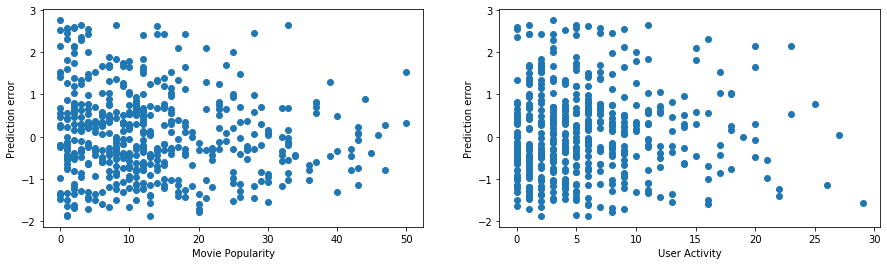

In [46]:
# only plot a subsample for higher readability
subn = 500 
fig, (ax0, ax1) = plt.subplots(ncols=2)
fig.set_figwidth(15)
ax0.scatter(movie_popularity[:subn], err[:subn])
ax0.set_ylabel('Prediction error')
ax0.set_xlabel('Movie Popularity')

ax1.scatter(user_activity[:subn], err[:subn])
ax1.set_ylabel('Prediction error')
ax1.set_xlabel('User Activity');

Above we plotted the prediction error of (a subset of) test ratings compared to the popularity of movies (left) and activity level of users (right). We note that:

- This empirical distribution looks symmetrical so there doesn't seem to be a bias toward lower or higher predictions
- The prediction errors seem to show that movies and users with more data have smaller prediction error (i.e., the data forms a "triangle" pointing to the right, this is much clearer when running w. more training data which we limit here to save time). This is intuitive, the more data you have about an item the more accurate should be the estimation of its parameters ($\theta_{\text{mid}}$). This could also be reinforced by the fact that we are splitting ratings randomly for train and test (versus splitting by user or item). Hence, popular movies and high-activity users have a great influence in the learning process.

### 2.3 Linear regression with tag features/covariates

We use a linear regression model as above but also model movie tags: 

$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i} \mathbf{+ x_{\text{tags}_i}\boldsymbol\theta_\text{tags}}
$$ 

The last term on the right-hand side (bolded) is the only difference wrt to our previous model.  

**Question 5:** How do you think that this new model will compare to the previous model of Section 2.2? Can you say something definitive about its performance? 

**Hint:** One model is a special case of another.

In [47]:
# This is very similar to how we constructed our dataset above except that we add the tags columns
X_tags = data_pd_dum.filter(regex=('('+attributes+"|tid_*"+')'))
print(X_tags.shape)

# Split Train/Test. Notice that we use the same seed as above to split the data in the same way.
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags.shape)

(19255, 8151)
(15404, 8151)


In [48]:
# Create linear regression object
regr_tags = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
regr_tags.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("fitting time: %.2f seconds" % fit_time)
print("number of parameters:", regr_tags.coef_.shape[0]+1)

fitting time: 12.19 seconds
number of parameters: 8152


In [49]:
print("number of parameters: %d" % regr_tags.coef_.shape[0])

number of parameters: 8151


In [50]:
# Make train predictions
y_train_pred = regr_tags.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_tags.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))

Train Mean squared error: 0.7264
Test Mean squared error: 0.9914


Remarks: We obtain a test MSE of 0.8571 for model 2.3 compared to a test MSE of 0.865 for model 2.2. So the tags do seem to provide slightly better test performance at the expense of a slightly larger model (968 extra parameters to fit) which takes about 30% longer to fit. Take this with a grain of salt because it is hardware dependent. But, this hints at the fact that the fitting algorithm is not linear (i.e., increasing the number of parameters by 10% yields an increase of 30% in running time).

***

### 2.4  Using our movie clusters as covariates in linear regression

Recall that in [Section 1.1](#tag_clustering) we clustered movies using their tag representations. Here we will use the cluster membership as additional covariates. Again the intuition is that this may capture dependencies between tags that would not be available otherwise. 

We start by preparing the data. We use the same operations as above except that we include the `tcluster_*` columns.

In [51]:
X_tags_cluster = data_pd_dum.filter(regex=('('+attributes+"|tid_*|tcluster_*)"))
display(X_tags_cluster.columns)

# Split Train/Test. Again we use the same fixed seed as above for comparison and reproducibility purposes
X_train_tags_cluster, X_test_tags_cluster, y_train_tags_cluster, y_test_tags_cluster = train_test_split(
    X_tags_cluster, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags_cluster.shape)

Index(['age', 'tid_1', 'tid_2', 'tid_3', 'tid_5', 'tid_6', 'tid_7', 'tid_9',
       'tid_10', 'tid_12',
       ...
       'tcluster_90', 'tcluster_91', 'tcluster_92', 'tcluster_93',
       'tcluster_94', 'tcluster_95', 'tcluster_96', 'tcluster_97',
       'tcluster_98', 'tcluster_99'],
      dtype='object', length=8251)

(15404, 8251)


We note that the we now use 10,148 covariates and that the model will also require this number of parameters (+1 for the intercept parameter). 

Now let us train a linear regression model using all available covariates. Models 2.2 and 2.3 are special cases of this model (2.4). The same argument with respect to performance applies as in our comparison of model 2.3 versus model 2.2.

In [52]:
# Create linear regression object
regr_tags_cluster = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr_tags_cluster.fit(X_train_tags_cluster, y_train_tags_cluster)

print("number of parameters: ", regr_tags_cluster.coef_.shape[0]+1)

number of parameters:  8252


In [53]:
# Make train predictions
y_train_pred = regr_tags_cluster.predict(X_train_tags_cluster)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags_cluster, y_train_pred))

# Make test predictions
y_test_pred = regr_tags_cluster.predict(X_test_tags_cluster)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags_cluster, y_test_pred))

Train Mean squared error: 0.7244
Test Mean squared error: 0.9920


Our results so far are: 

| Model        | Test MSE           |
| ------------- |:-------------:| 
| 2.2 (Linear Reg. w. basic features)     | 1.031 | 0.8650  |
| 2.3 (2.2 + movie tags)     | 0.9914 | 0.8571 |
| 2.4 (2.3 + movie clusters) | 0.9920 | 0.8570      |


We note that while tags help, clusters provide no help. This seems to show that clusters do not provide much information beyond what is already directly accessible through the movie tags.

### 2.5 Fitting a non-linear model 

So far we have studied the effect of using different features on a linear model. We note that adding features seems to help, as long as the features provide novel and predictive information and are not redundant. 

Here we explore a non-linear model, a one-hidden layer neural network for regression. The task and the data are the same as before, only the model changes.

**Neural network basics:** 
- A neural network is made up of interconnected *neurons*. Each neuron computes a few simple operations. 
- In a *feed-forward network*, neurons are organized into sets called *layers*. 
 - Neurons in each layer get their inputs from the previous layer and send their outputs to the next layer. 
 - The first layer is called the *input layer* it provides data to the next layer. The last layer is the *output layer* it provides a prediction $\hat{y}$. 
 - Layers in between the input layer and the output layer are called *hidden layers*. Each neuron in the hidden layers is a linear regression model followed by a non-linear function (*activation function*): $f(x) = \sum_i x_i \theta_i$. 
  - While the number of neurons in the input and output layers are fixed by the data (the number of features and the number of predictions). 
  - The number of neurons of a hidden layer is a hyperparameter. Another hyperparameter is the number of hidden layers. 

Mathematically for a regression task (with a single output), a one-hidden layer neural net is: 
$$ 
f(x) = f_\text{o} ( \sum_{j=0}^{|\text{hidden n.}|} \theta'_{j} f_\text{h}( \sum_{i=0}^{|p|}\theta_{ij} x_i ) ) 
$$ 
where
- $\theta_{ij}$ are the parameters of input $i$ and neuron $j$ in the hidden layer.
- $f_h$ is the activation function of the hidden layer
- $\theta'_{j}$ are the parameters that connect the neuron $j$ in the hidden layer to the output layer.
- $f_o$ is the activation function of the output layer

A intuitive way of visualization a neural net (especially large ones) is to draw neurons as nodes and connections between neurons as arcs:

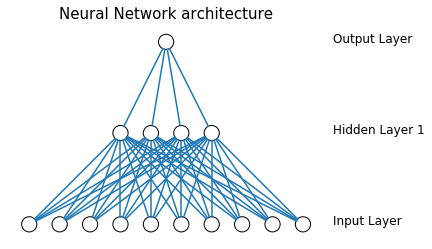

In [54]:
# a 1 hidden layer neural net, where the input has 10 dimensions (p=10) and the output 1
input_dims = 10 # p 
hidden_layers_size = [4] # number of hidden neurons for each hidden layer (adding a dimension adds a layer)
output_dims = 1 # number of outputs

network = DrawNN( [input_dims] + hidden_layers_size + [output_dims] )
network.draw()

In [58]:
# Fit a neural network on this data. 
regr_nn = neural_network.MLPRegressor(alpha=0.1, # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True)
start = time.time()
regr_nn.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("fitting time: %.2f seconds" % fit_time)
print("number of parameters:", reduce(lambda x,y: x+y, 
                                       list(map(lambda x: x.size, regr_nn.coefs_+regr_nn.intercepts_)) ))

Iteration 1, loss = 2.99241182
Validation score: -0.609613
Iteration 2, loss = 0.94710873
Validation score: -0.438326
Iteration 3, loss = 0.83536802
Validation score: -0.305829
Iteration 4, loss = 0.74287393
Validation score: -0.189473
Iteration 5, loss = 0.66655996
Validation score: -0.096586
Iteration 6, loss = 0.60543548
Validation score: -0.024242
Iteration 7, loss = 0.55771092
Validation score: 0.029477
Iteration 8, loss = 0.52139337
Validation score: 0.067442
Iteration 9, loss = 0.49253547
Validation score: 0.098617
Iteration 10, loss = 0.47058620
Validation score: 0.118341
Iteration 11, loss = 0.45332567
Validation score: 0.135879
Iteration 12, loss = 0.43905250
Validation score: 0.148215
Iteration 13, loss = 0.42743815
Validation score: 0.158203
Iteration 14, loss = 0.41719953
Validation score: 0.163628
Iteration 15, loss = 0.40984199
Validation score: 0.167915
Iteration 16, loss = 0.40153506
Validation score: 0.173954
Iteration 17, loss = 0.39527593
Validation score: 0.180319


Much like previous models we can regularize a neural net to combat overfitting:
- Here we use the same L2-penalty regularizer on all parameters. The strength of this regularizer is given by $\alpha$. 
- In addition, we use a second regularizer called `early-stopping`. Learning the parameters of a neural network is done iteratively using a method called gradient descent (as opposed to linear regression, there is not analytical solution for the parameters given the objective function). Early stopping simply evaluates validation error after each iteration. It stops learning when validation error stops improving. This can happen before the training loss converges. When it does not, then this regularizer has no effect on learning. In `scikit-learn`, the MLPRegressor class with `early_stopping=True` automatically splits a validation set from the training set to be used by this regularizer. The disadvantage, of course, is that this reduces the amount of data used to fit parameters. 


Note: the training loss of this MLP model is the MSE. However, the reported numbers above "Iteration 19, loss = XX" do not seem to correspond to.

In [59]:
# Make train predictions
y_train_pred = regr_nn.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_nn.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
#Train Mean squared error: 0.6623
#Test Mean squared error: 1.0465

Train Mean squared error: 0.6843
Test Mean squared error: 1.0284


Here is our updated table of results

| Model        | Test MSE           |
| ------------- |:-------------:| 
| 2.2 (Linear Reg. w. basic features)     | 1.031 | 0.8650  |
| 2.3 (2.2 + movie tags)     | 0.9914 | 0.8571 |
| 2.4 (2.3 + movie clusters) | 0.9920 | 0.8570      |
| 2.5 (Neural Network w. features from 2.3) | 1.0284 | 0.8650 | 

Although neural networks are very powerful models, on this task the performance of our neural net does not outperform a simpler linear regression model. This of course does not mean that a different neural net (for example, one with more neurons per layer or more layers or just one trained from different hyperparameters) could not do better. 

<a id="concluding-remarks"></a>
### Section 3. Concluding Remarks

The goal of this tutorial was to put in practice some of the principles that were discussed in this morning's presentation but also to make you start thinking about recommender systems data. We will of course spend a lot of time in the next couple of days thinking about preference data including where it's coming from and how to model it. 

Here are a few more parting thoughts: 

#### Machine Learning

As you might have noticed, applied machine learning is a very empirical endeavour. Once you have data in the right format, it is typical to fit it using several models, each time trying to understand the advantages/disadvantages of each model and getting a more thorough understanding of the data. In practice, this last part may be crucial and we did not adress this last part much in this tutorial (instead focussing on the models themeselves).


#### Scikit-learn
`scikit-learn` is a powerful ML library. It is meant as a model (and data pre-processing) toolbox. It provides an interface to a wide variety of models, it is actively developped, and in general seen as a very good plateform. It is also open source and free to use.

Model Selection, i.e., which model should I use for a particular dataset/task can be daunting. [This page](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) provides some tips particular to `scikit-learn`. In general, when working on a new task/dataset it is often useful to try and compare different models. Remember that in practice (mean) test-performance is only one of the possible desiderata (others include running time both for training and other metrics like false positive rates).

Note that `scikit-learn` does not fit every use case. For example, its support of modern neural networks is fairly modest. It is also not meant as a development plateform for new models.

#### Other packages

Software is one of the reasons behind the rise of modern machine learning. Modern software automatize a number of tasks which allow programmers and researchers alike to be much more efficient. `scikit-learn` is one popular package for fitting machine learning models but there exist others (both applied and also for exploration/development purposes). All in all, it can be useful to know about these packages but (in my opinion) it is more useful to have a good understanding of the fundamentals of the field as the package landscape changes rapidly and one can always learn one more. 


#### Food for thought
 - In our models we assumed that ratings were the dependent variable (y) and that we had covariates (e.g., features of users and movies). Imagine a setting where we don't have any features or, somewhat equivalently, had features that were not predictive of ratings. In that case the linear regression model would be: 
 
$$
f(x_{ui}) = \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$ 
 
 
- **Question 6:** What's wrong with the above model? Try to think about it for a minute or two before looking at the answer.



- As we will see tomorrow, many models take ratings as output **and** as input. For example, one could take a user's previous ratings and try to predict one's future ratings (for example using an auto-encoder model). This is a nice way to build models that do not require any user/item covariates (and these models can also be extended when that data exist).

## References


Scikit-learn
- [Documentation](https://scikit-learn.org/stable/documentation.html)
- [Tutorials](https://scikit-learn.org/stable/tutorial/index.html)
- [Help for model selection](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)


Books
- [Deep Learning](https://www.deeplearningbook.org/), a recent book by some of the leaders in the field. Part I provides a good introduction to the fundamental ML concepts as well as to the mathematical tools needed for modern applied machine learning. It is available online for free.
- [The Elements of Statistical Learning:](https://web.stanford.edu/~hastie/ElemStatLearn/), a classic which remains a very good reference (and it's available online for free in PDF format).

